In [13]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)



In [453]:
raw_train = pd.read_csv('../../data/train.csv', parse_dates=['timestamp'], index_col="id")  
raw_test = pd.read_csv('../../data/test.csv', parse_dates=['timestamp'], index_col="id")  
train = pd.read_csv('../data/clean_train_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_all_cols_chase.csv', parse_dates=['timestamp'], index_col="id")
locales = pd.read_csv('../../data/okurg.csv')
district_indices = pd.read_csv('../data/district_indices.csv')
gold = pd.read_csv('../data/gold_rub.csv')
oil = pd.read_csv('../data/oil_urals.csv',parse_dates=['timestamp'])
moscow = pd.read_csv('../data/moscow_index.csv',header=None)

In [454]:
train.drop('okurg_district',inplace=True,axis=1)
train = pd.merge(train,locales, how="left", on="sub_area").reset_index(drop=True).set_index(train.index)

In [455]:
moscow.columns = ['date','price']

In [456]:
moscow['month_year'] = pd.PeriodIndex(moscow['date'], freq='M').strftime('%m/%y')
oil['month_year'] = pd.PeriodIndex(oil['timestamp'], freq='M').strftime('%m/%y')

In [457]:
oil = oil.groupby('month_year').mean().reset_index()
oil['oil_rub'] = oil.oil_urals * oil.usdrub

In [458]:
moscow = moscow.groupby('month_year').price.mean().to_frame().reset_index()

In [459]:
econ = gold.merge(moscow,how="left",on="month_year")
econ.price = econ.price / econ.loc[0,'price']

In [460]:
econ.columns = ['month_year','gold_index','moscow_index']

In [461]:
econ = econ.merge(oil[['month_year','oil_rub']],how="left",on="month_year")
# econ.price = econ.oil_rub / econ.loc[0,'oil_rub']

In [658]:
econ.head()

,month_year,gold_index,moscow_index,oil_rub
0,01/10,1.000000,1.000000,1.000000
1,02/10,0.978378,1.019987,0.969134
2,03/10,0.986234,1.025929,1.002443
3,04/10,1.012364,1.042134,1.065069
4,05/10,1.031779,1.086429,0.981117


In [463]:
econ.oil_rub = econ.oil_rub / econ.loc[0,'oil_rub']

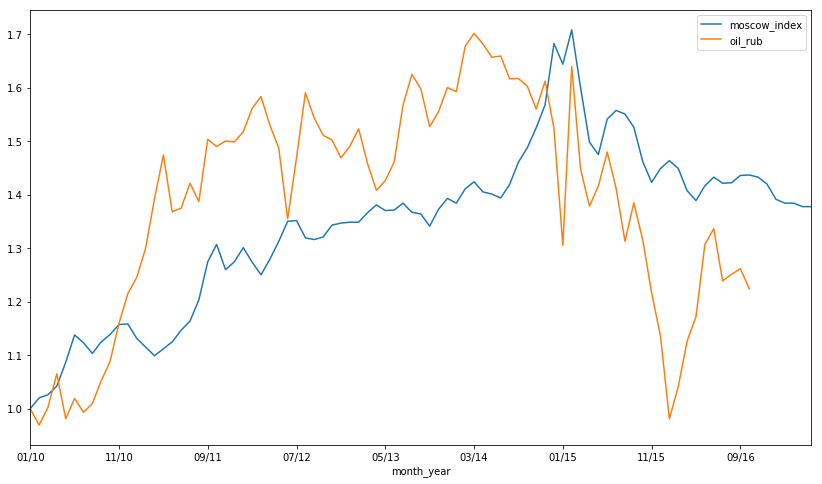

In [659]:
fig, ax = plt.subplots(figsize=(14,8))
econ.drop('gold_index',axis=1).plot.line(ax=ax,x='month_year')

In [465]:
raw_train = pd.merge(raw_train,locales, how="left", on="sub_area").reset_index(drop=True).set_index(raw_train.index)

In [466]:
def getKremlinGroup(df, id):
    """ returns the group that are the same distance from the kremlin"""
    x = df.loc[id,'kremlin_km']
    return df.loc[df.kremlin_km==x,:]

In [467]:
bad_floor = raw_train[raw_train.max_floor == 1]

In [468]:
kremlin_counts = raw_train.groupby('kremlin_km').timestamp.count()

In [469]:
raw_train[raw_train.floor > raw_train.max_floor]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [470]:
train.groupby('okurg_district')

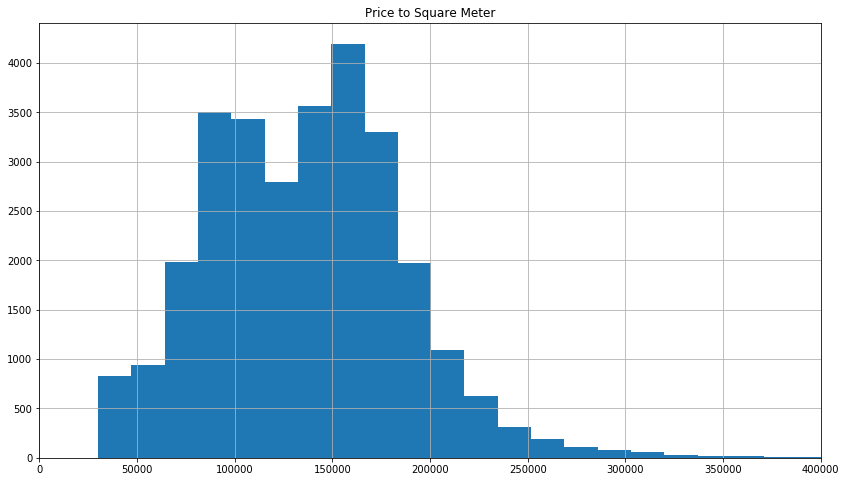

In [471]:
fig, ax = plt.subplots(figsize=(14,8))
ax.set_xlim((0,400000))
ax.set_title('Price to Square Meter')
train.price_full.hist(bins=30)

In [472]:
train['quarter'] = pd.PeriodIndex(train['timestamp'], freq='Q').strftime('%Q/%y')

In [473]:
train_grouped = train.groupby(['okurg_district','quarter']).median()

In [474]:
train_grouped.reset_index(inplace=True)

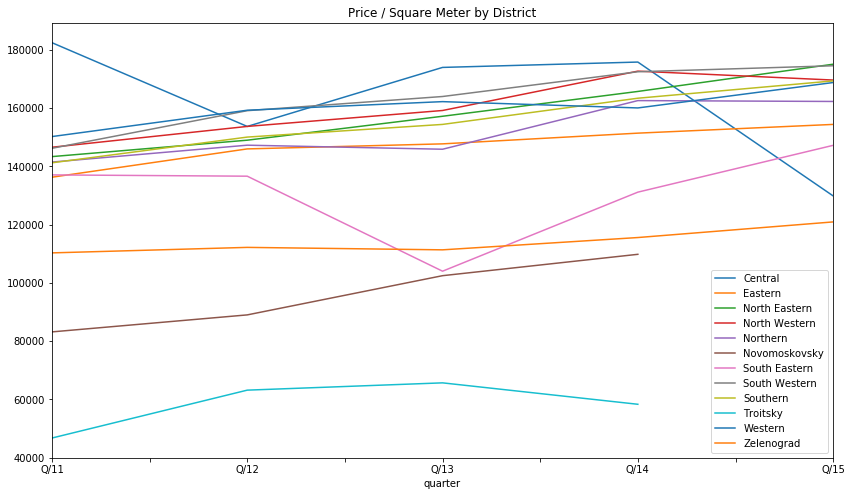

In [475]:
fig, ax = plt.subplots(figsize=(14,8))
plt.title("Price / Square Meter by District")
for label, df in train_grouped.groupby('okurg_district'):
    df.plot(x="quarter", y="price_full",ax=ax, label=label)

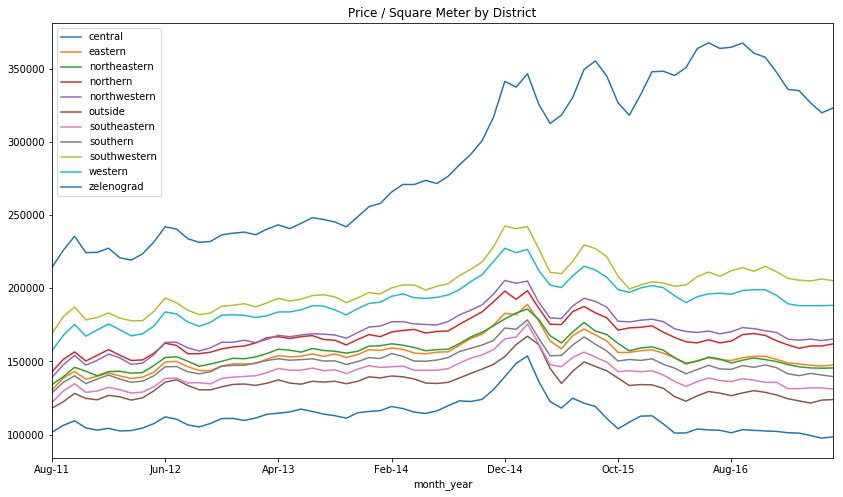

In [476]:
fig, ax = plt.subplots(figsize=(14,8))
plt.title("Price / Square Meter by District")
for label, df in district_indices.groupby('district'):
    df.plot(x="month_year", y="price",ax=ax, label=label)

In [477]:
raw = pd.concat([raw_train,raw_test])
clean = pd.concat([train,test])

In [478]:
raw['kitch_to_life'] = raw.kitch_sq / raw.life_sq
raw['life_to_full'] = raw.life_sq / raw.full_sq

In [479]:
raw.loc[raw.kitch_to_life > 1,'kitch_to_life'] = np.nan
raw.loc[raw.life_to_full > 1,'life_to_full'] = np.nan


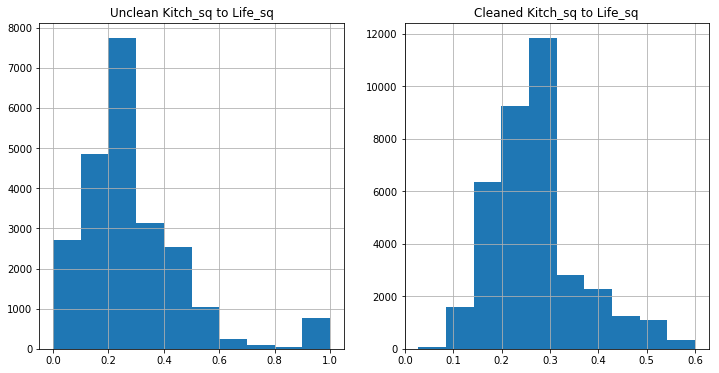

In [480]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
axs[0].set_title('Unclean Kitch_sq to Life_sq')
axs[1].set_title('Cleaned Kitch_sq to Life_sq')
raw.kitch_to_life.hist(ax=axs[0])
clean.kitch_to_life.hist(ax=axs[1])

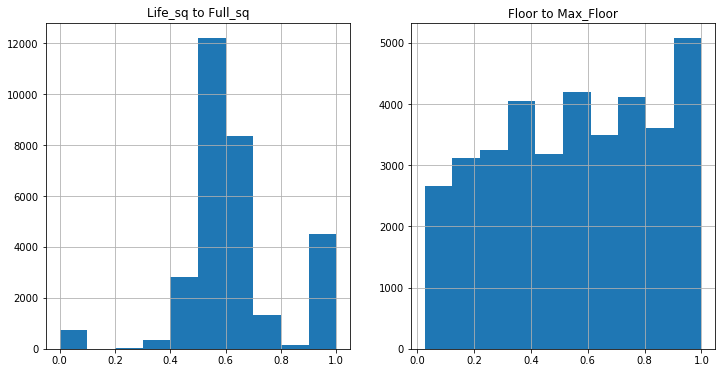

In [481]:
clean['floor_to_max'] = clean.floor / clean.max_floor
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
axs[0].set_title('Life_sq to Full_sq')
axs[1].set_title('Floor to Max_Floor')
raw.life_to_full.hist(ax=axs[0])
clean.floor_to_max.hist(ax=axs[1])

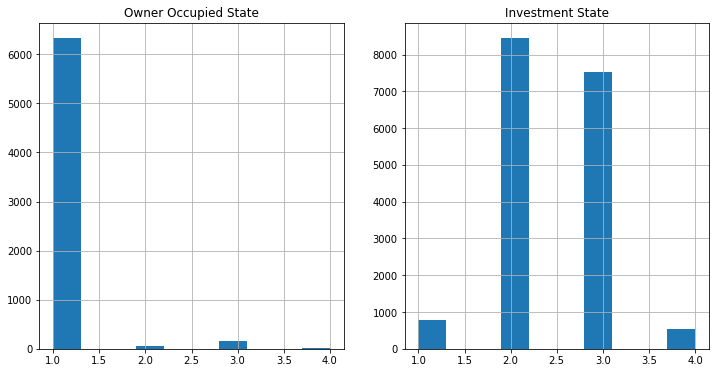

In [482]:
raw.loc[raw.state>5,"state"] = np.nan
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
axs[0].set_title('Owner Occupied State')
axs[1].set_title('Investment State')

raw[raw.product_type == 'OwnerOccupier'].state.hist(ax=axs[0])
raw[raw.product_type == 'Investment'].state.hist(ax=axs[1])

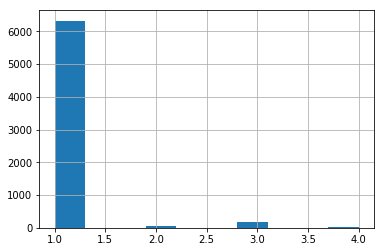

In [483]:
raw[raw.product_type == 'OwnerOccupier'].state.hist()

In [484]:
train.groupby('okurg_district').count()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [485]:
train['month_year'] = pd.PeriodIndex(train['timestamp'], freq='M').strftime('%m/%y')
train['quarter'] = pd.PeriodIndex(train['timestamp'], freq='Q').strftime('%QQ%y')


In [486]:
by_month = train.groupby(['okurg_district','month_year'])

In [495]:
cols = ['full_sq', 'life_sq', 'floor', 'max_floor',
        'build_year', 'num_room', 'kitch_sq', 'state']
temp = raw_train[cols] == 0

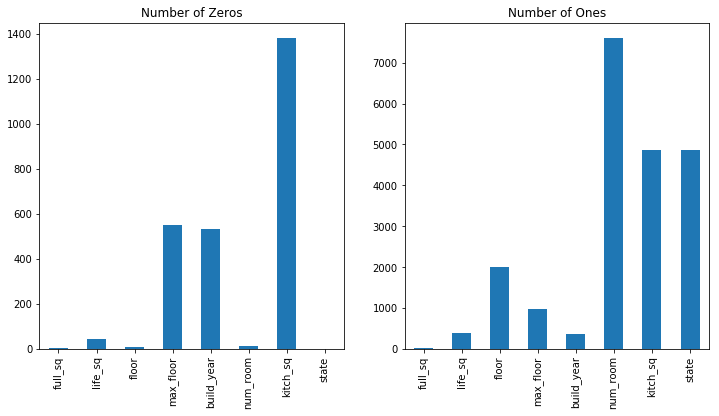

In [496]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))
axs[0].set_title('Number of Zeros')
axs[1].set_title('Number of Ones')

(raw_train[cols] == 0).apply(sum).plot.bar(ax=axs[0])
(raw_train[cols] == 1).apply(sum).plot.bar(ax=axs[1])

In [497]:
raw_train['price_full'] = raw_train.price_doc / raw_train.full_sq 
raw_train.loc[raw_train.price_full>600000,'price_full'] = np.nan
raw_train.loc[raw_train.price_full<25000,'price_full'] = np.nan
state_summary = raw_train.groupby(['state','product_type'])

In [498]:
state_summary.price_full.describe()[['count','mean']].round()
# state_summary.okurg_district

count      mean
state product_type                   
1.0   Investment      506.0  131914.0
      OwnerOccupier  4310.0  117212.0
2.0   Investment     5616.0  150521.0
      OwnerOccupier    42.0  121890.0
3.0   Investment     5511.0  157818.0
      OwnerOccupier   133.0  133730.0
4.0   Investment      408.0  182539.0
      OwnerOccupier     9.0  172446.0
33.0  Investment        1.0  243243.0

In [499]:
type_group = raw_train.groupby('product_type').okurg_district

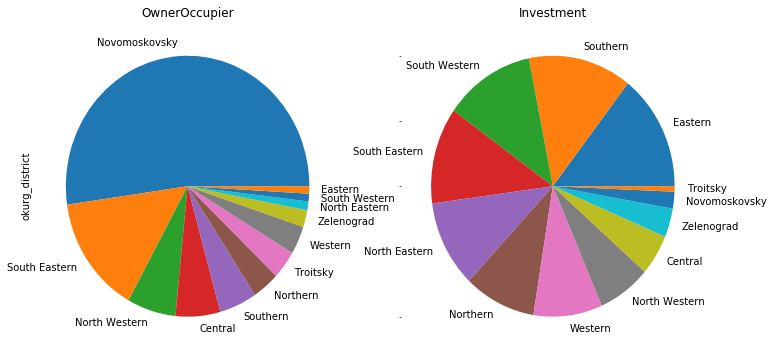

In [500]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,6))


axs[1].set_title('OwnerOccupied')

i = 1
for group in type_group:
    axs[i].set_title(group[0])
#     axs[i].set_label('')
    group[1].value_counts().plot.pie(ax=axs[i],sharey=True)
    i = i - 1

In [501]:
from random import random

In [502]:
print raw_test[raw_test.max_floor==1].groupby('product_type').product_type.value_counts()
print raw_train[raw_train.max_floor==1].groupby('product_type').product_type.value_counts()

product_type   product_type 
Investment     Investment         4
OwnerOccupier  OwnerOccupier    395
Name: product_type, dtype: int64
product_type   product_type 
Investment     Investment        12
OwnerOccupier  OwnerOccupier    961
Name: product_type, dtype: int64


In [503]:
train[train.kremlin_km>23.373697].iloc[0,:].kremlin_km

27.174806109999999

In [504]:
# raw_train.groupby('kremlin_km').sub_area

In [505]:
cnts = raw_train.nunique()
cnts[(cnts>11845) & (cnts<11860)]

kindergarten_km                      11852
park_km                              11852
public_transport_station_km          11851
public_transport_station_min_walk    11852
water_km                             11851
mkad_km                              11852
ttk_km                               11852
sadovoe_km                           11852
bulvar_ring_km                       11852
kremlin_km                           11852
big_road1_km                         11852
big_road2_km                         11852
railroad_km                          11852
oil_chemistry_km                     11852
nuclear_reactor_km                   11852
radiation_km                         11852
power_transmission_line_km           11852
thermal_power_plant_km               11852
ts_km                                11849
basketball_km                        11852
hospice_morgue_km                    11852
big_church_km                        11852
church_synagogue_km                  11852
mosque_km  

11852


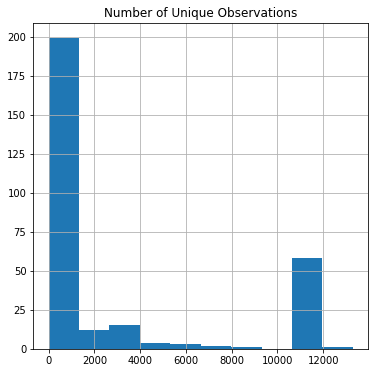

In [506]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_title("Number of Unique Observations")
print raw_train.kremlin_km.nunique()
raw_train.nunique().hist()

In [507]:
temp = raw_train.groupby('kremlin_km').kremlin_km.value_counts().sort_values(ascending=False).to_frame()

In [510]:
temp.columns = ['count']

In [511]:
sum(temp['count'] > 5)

452

In [512]:
sum(temp[0:452]["count"])

12610

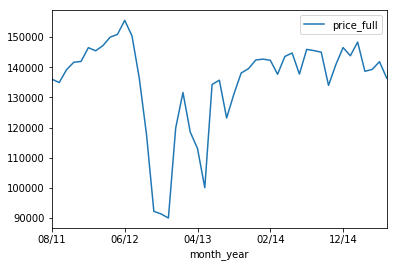

In [513]:
price_multiples = train.groupby('month_year').price_full.median().reset_index()
price_multiples['date'] = pd.to_datetime(price_multiples.month_year,format="%m/%y")
price_multiples.sort_values('date',inplace=True)
price_multiples.set_index('month_year',inplace=True)
price_multiples.drop('date',axis=1,inplace=True)
price_multiples.plot.line()

In [518]:
price_sub_area = train.groupby(['okurg_district','month_year'])
train['quarter'] = 

In [531]:
train['quarter'] = pd.PeriodIndex(train['timestamp'], freq='Q').strftime('%qQ%y')

In [532]:
quarters = train.quarter.unique()

In [533]:
quarters

array([u'3Q11', u'4Q11', u'1Q12', u'2Q12', u'3Q12', u'4Q12', u'1Q13',
       u'2Q13', u'3Q13', u'4Q13', u'1Q14', u'2Q14', u'3Q14', u'4Q14',
       u'1Q15', u'2Q15'], dtype=object)

In [535]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

plt.stackplot(quarters,
          [group[1].price_full.count() for group in train.groupby(['okurg_district','quarter']).groups])
plt.xlim(1,12)

# creating the legend manually
plt.legend([mpatches.Patch(color='#377EB8'),  
            mpatches.Patch(color='#55BA87'), 
            mpatches.Patch(color='#7E1137')], 
           ['chickenpox','mumps','measles'])
plt.show()

AttributeError: 'unicode' object has no attribute 'price_full'

In [628]:
train_group = train.groupby(['okurg_district','quarter']).price_full.count()

In [629]:
temp = train_group.unstack().transpose().reset_index()

In [630]:
temp['qtr'] = temp.quarter.apply(lambda x: str(x)[0])
temp['year'] = temp.quarter.apply(lambda x: str(x)[-2:])

In [631]:
multiples = train.groupby(['quarter']).price_full.median().reset_index()
temp = temp.merge(multiples,how="left",on="quarter")

temp.sort_values(['year','qtr'],inplace=True)
temp.set_index('quarter',drop=True,inplace=True)
temp.drop(['qtr','year'],axis=1,inplace=True)
temp

,Central,Eastern,North Eastern,North Western,Northern,Novomoskovsky,South Eastern,South Western,Southern,Troitsky,Western,Zelenograd,price_full
quarter,,,,,,,,,,,,,
3Q11,2.0,7.0,5.0,5.0,3.0,NaN,7.0,NaN,7.0,NaN,4.0,1.0,135820.895522
4Q11,32.0,115.0,73.0,35.0,55.0,NaN,78.0,62.0,84.0,NaN,58.0,21.0,141025.641026
1Q12,65.0,139.0,103.0,82.0,77.0,NaN,107.0,103.0,123.0,NaN,77.0,28.0,146666.666667
2Q12,43.0,113.0,88.0,92.0,77.0,5.0,104.0,113.0,123.0,1.0,68.0,27.0,151853.878420
3Q12,53.0,125.0,102.0,94.0,105.0,257.0,120.0,85.0,102.0,10.0,88.0,33.0,137731.395349
4Q12,101.0,62.0,61.0,105.0,74.0,729.0,134.0,71.0,87.0,10.0,68.0,41.0,90782.300000
1Q13,66.0,90.0,67.0,110.0,67.0,350.0,206.0,85.0,110.0,2.0,70.0,31.0,121114.551084
2Q13,61.0,118.0,128.0,156.0,102.0,539.0,314.0,107.0,153.0,9.0,87.0,30.0,111111.111111
3Q13,104.0,149.0,146.0,169.0,143.0,404.0,366.0,156.0,165.0,26.0,110.0,34.0,131339.285715


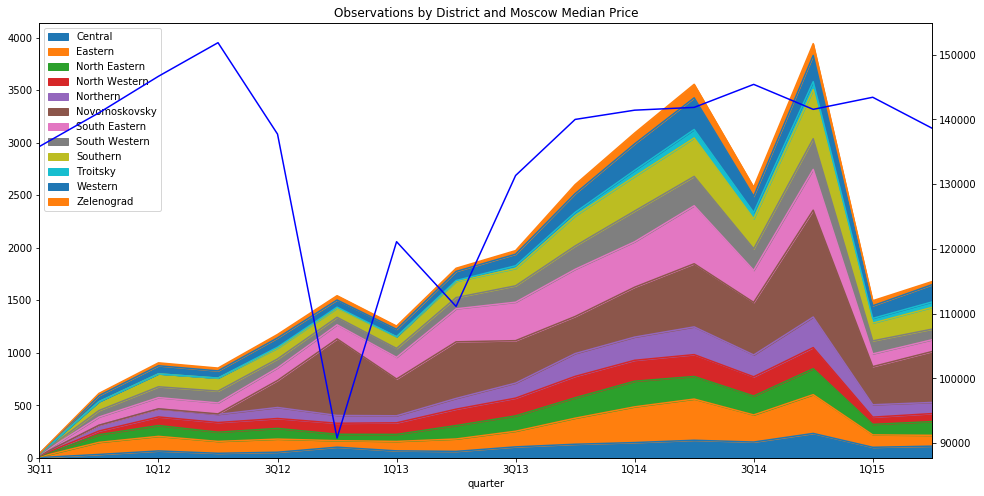

In [656]:
fig, axs = plt.subplots(figsize=(16,8))
patches, labels = ax.get_legend_handles_labels()

axs.set_title('Observations by District and Moscow Median Price')
temp.iloc[:,0:12].plot.area(ax=axs)
temp.price_full.plot.line(ax=axs,secondary_y=True,c="b")

In [ ]:
raw_train